In [66]:
% matplotlib inline

In [67]:
import numpy as np
import matplotlib.pyplot as plt
import model_list, models, fitting
import matplotlib.lines as mlines

from utils import rj2cmb

In [68]:
mean_beta = 1.6
mean_temp = 20.
sigma_beta = .2
sigma_temp = 4.

In [69]:
test = model_list.prob1mbb_model
control = model_list.dust_model

In [71]:
DUST_I = 50.
DUST_P = 5. / 1.41

test_smallvar = models.ProbSingleMBB(amp_I=rj2cmb(353e9, DUST_I),
                             amp_Q=rj2cmb(353e9, DUST_P),
                             amp_U=rj2cmb(353e9, DUST_P),
                             dust_beta=1.6, dust_T=20.,
                             sigma_beta=.1 * sigma_beta, sigma_temp=.1 * sigma_temp)

In [5]:
nu = np.logspace(np.log10(30), np.log10(500), 7) * 1e9

In [16]:
control.params()

array([ 1.6, 20. ])

In [51]:
fsigma_T = 1.
fsigma_P = 10e3

In [52]:
D_vec, Ninv = fitting.generate_data(nu, fsigma_T, fsigma_P, [test])

(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T', 'sigma_beta', 'sigma_temp']


In [53]:
beam_mat = np.identity(3*len(nu)) # Beam model
params = [test.amp_I, test.amp_Q, test.amp_U, test.dust_beta, test.dust_T, test.sigma_beta, test.sigma_temp]
pnames = ('dust_beta', 'dust_T', 'sigma_beta', 'sigma_temp')
initial_vals = (mean_beta, mean_temp, sigma_beta, sigma_temp)
parent_model = 'mbb'

data_spec = (nu, D_vec, Ninv, beam_mat)
param_spec = (pnames, initial_vals, parent_model)

In [13]:
params, param_spec

([645.2749353774365,
  45.76417981400259,
  45.76417981400259,
  1.6,
  20.0,
  0.2,
  4.0],
 (('dust_beta', 'dust_T', 'sigma_beta', 'sigma_temp'),
  (1.6, 20.0, 0.2, 4.0),
  'mbb'))

In [55]:
fitting.lnprob_joint(params, data_spec, [control], param_spec)

['dust_beta', 'dust_T']
dust_T ['dust_beta', 'dust_T'] [1.6, 20.0, 0.2, 4.0]
dust_beta ['dust_beta', 'dust_T'] [1.6, 20.0, 0.2, 4.0]


matrix([[-376.41573175]])

In [21]:
np.shape(D_vec)

(21, 1)

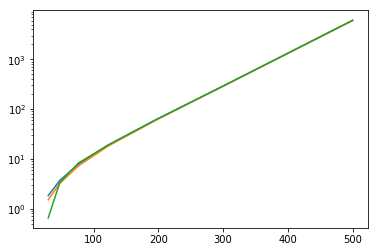

In [56]:
plt.semilogy(nu/1e9, test.scaling(nu)[0] * test.amps()[0])
plt.semilogy(nu/1e9, control.scaling(nu)[0] * control.amps()[0])
plt.semilogy(nu/1e9, D_vec[:7])

In [57]:
I_test = test.scaling(nu)[0] * test.amps()[0]
I_control = control.scaling(nu)[0] * control.amps()[0]
I_data = np.array(D_vec[:7]).flatten()
err_I = 1./np.sqrt(np.diag(Ninv))[:7]

<ErrorbarContainer object of 3 artists>

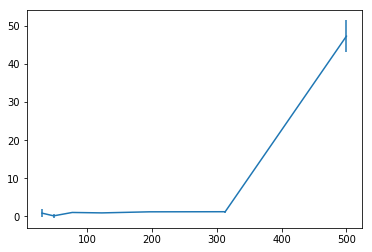

In [60]:
#plt.errorbar(nu/1e9, I_test - I_data, yerr=err_I)
plt.errorbar(nu/1e9, np.abs(I_control - I_data), yerr=err_I)


In [31]:
D_vec[:7,0].shape

(7, 1)

In [52]:
realizations = 1000
chi2s = np.zeros(realizations)

for i in range(realizations):
    D_vec, Ninv = fitting.generate_data(nu, fsigma_T, fsigma_P, [control])
    data_spec = (nu, D_vec, Ninv, beam_mat)
    param_spec = (pnames, initial_vals, parent_model)
    chi2s[i] = fitting.lnprob_joint(params, data_spec, [control], param_spec)
    

(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['du

(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['du

(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['du

(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['du

(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['du

(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['du

(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['dust_beta', 'dust_T']
(FITTING.PY) Parameters in the input model:
['du

In [ ]:
2. * chi2s1.sum() / realizations + len(D_vec)

Text(0.5,1,'fitting low var to MBB')

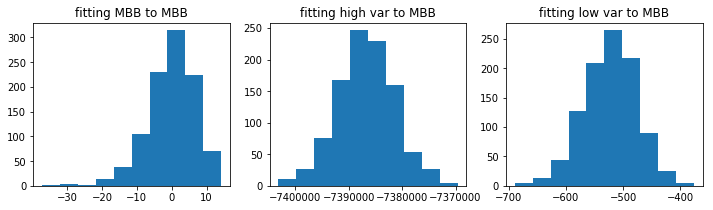

In [53]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
fig.set_figwidth(12)
fig.set_figheight(3)

ax1.hist(2 * chi2s + len(D_vec))
ax1.set_title('fitting MBB to MBB')

ax2.hist(2 * chi2s1 + len(D_vec))
ax2.set_title('fitting high var to MBB')

ax3.hist(2 * chi2s2 + len(D_vec))
ax3.set_title('fitting low var to MBB')

In [55]:
fitting.model_test(nu, D_vec, Ninv, [control], initial_vals=None, burn=500, 
               steps=1000, cmb_amp_in=None, sample_file=None)

emcee: Exception while calling your likelihood function:
  params: [ 1.6033243  20.03806831]
  args: ((array([3.00000000e+10, 4.79471407e+10, 7.66309432e+10, 1.22474487e+11,
       1.95743382e+11, 3.12844516e+11, 5.00000000e+11]), matrix([[ 1.51648215e+00],
        [ 3.23113977e+00],
        [ 7.22609869e+00],
        [ 1.80764241e+01],
        [ 5.94383146e+01],
        [ 3.51181459e+02],
        [ 6.10386569e+03],
        [-5.10268499e+03],
        [ 9.85349251e+02],
        [-1.82457505e+03],
        [-2.63958215e+02],
        [-1.12259873e+03],
        [-5.52954584e+03],
        [-2.98545665e+04],
        [ 6.03494821e+03],
        [-1.13956617e+03],
        [ 9.13263448e+02],
        [-6.63493281e+02],
        [ 1.53325097e+02],
        [ 4.66670435e+03],
        [-5.97599838e+03]]), array([[8.54922363e+03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 

Traceback (most recent call last):
  File "/Users/Lisa/anaconda2/lib/python2.7/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "fitting.py", line 55, in lnprob
    F_fg, F_cmb, F = F_matrix(pvals, nu, models_fit, param_spec)
  File "fitting.py", line 145, in F_matrix
    raise ValueError("The first model in the models_fit list should be a "
ValueError: The first model in the models_fit list should be a CMB() object.


ValueError: The first model in the models_fit list should be a CMB() object.

In [65]:
fitting.joint_mcmc(data_spec, [test], param_spec, nwalkers=100, 
               burn=500, steps=1000, nthreads=2, sample_file=None)

['dust_beta', 'dust_T', 'sigma_beta', 'sigma_temp']
['dust_beta', 'dust_T', 'sigma_beta', 'sigma_temp']
dust_T ['dust_beta', 'dust_T', 'sigma_beta', 'sigma_temp'] [3.99996181]
dust_T ['dust_beta', 'dust_T', 'sigma_beta', 'sigma_temp'] [4.00345315]
emcee: Exception while calling your likelihood function:
emcee: Exception while calling your likelihood function:
  params: [ 1.59838473 20.0091907   0.19998033  3.99996181]
  params: [ 1.59561861 19.98819078  0.20004651  4.00345315]
  args: ((array([3.00000000e+10, 4.79471407e+10, 7.66309432e+10, 1.22474487e+11,
       1.95743382e+11, 3.12844516e+11, 5.00000000e+11]), matrix([[ 6.50991169e-01],
        [ 3.37255890e+00],
        [ 8.25525150e+00],
        [ 1.89943990e+01],
        [ 6.06388664e+01],
        [ 3.52408039e+02],
        [ 6.05649618e+03],
        [ 2.87338563e+04],
        [-1.10429951e+03],
        [ 8.48289707e+02],
        [ 6.00522366e+02],
        [ 5.96359254e+02],
        [ 1.49549492e+03],
        [ 3.79540725e+04],
  

        0., 0., 0., 0., 1.]])), [<models.ProbSingleMBB object at 0x1a2115cd10>], (('dust_beta', 'dust_T', 'sigma_beta', 'sigma_temp'), (1.6, 20.0, 0.2, 4.0), 'mbb'))  args: ((array([3.00000000e+10, 4.79471407e+10, 7.66309432e+10, 1.22474487e+11,
       1.95743382e+11, 3.12844516e+11, 5.00000000e+11]), matrix([[ 6.50991169e-01],
        [ 3.37255890e+00],
        [ 8.25525150e+00],
        [ 1.89943990e+01],
        [ 6.06388664e+01],
        [ 3.52408039e+02],
        [ 6.05649618e+03],
        [ 2.87338563e+04],
        [-1.10429951e+03],
        [ 8.48289707e+02],
        [ 6.00522366e+02],
        [ 5.96359254e+02],
        [ 1.49549492e+03],
        [ 3.79540725e+04],
        [ 7.90670538e+03],
        [-1.13289322e+04],
        [-8.41991790e+02],
        [ 2.20715226e+02],
        [-4.12950590e+02],
        [ 4.39798608e+02],
        [-1.27314638e+04]]), array([[8.54922363e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 

        0., 0., 0., 0., 1.]])), [<models.ProbSingleMBB object at 0x1a2170d0d0>], (('dust_beta', 'dust_T', 'sigma_beta', 'sigma_temp'), (1.6, 20.0, 0.2, 4.0), 'mbb'))

  kwargs: {}
  kwargs: {}
  exception:
  exception:


Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/Lisa/anaconda2/lib/python2.7/site-packages/emcee/ensemble.py", line 519, in __call__
  File "/Users/Lisa/anaconda2/lib/python2.7/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)
    return self.f(x, *self.args, **self.kwargs)
  File "fitting.py", line 98, in lnprob_joint
  File "fitting.py", line 98, in lnprob_joint
    logpr = ln_prior(pvals, models_fit)
    logpr = ln_prior(pvals, models_fit)
  File "fitting.py", line 39, in ln_prior
  File "fitting.py", line 39, in ln_prior
    val = pvals[pnames.index(pn)] # Current value of parameter
    val = pvals[pnames.index(pn)] # Current value of parameter
IndexError: index 1 is out of bounds for axis 0 with size 1
IndexError: index 1 is out of bounds for axis 0 with size 1


['dust_beta', 'dust_T', 'sigma_beta', 'sigma_temp']
['dust_beta', 'dust_T', 'sigma_beta', 'sigma_temp']
dust_T ['dust_beta', 'dust_T', 'sigma_beta', 'sigma_temp'] [4.00086695]
dust_T ['dust_beta', 'dust_T', 'sigma_beta', 'sigma_temp'] [3.99336571]
emcee: Exception while calling your likelihood function:
emcee: Exception while calling your likelihood function:
  params: [ 1.59918457 19.97570899  0.20001967  4.00086695]
  params: [ 1.59743843 19.96905647  0.20021929  3.99336571]
  args: ((array([3.00000000e+10, 4.79471407e+10, 7.66309432e+10, 1.22474487e+11,
       1.95743382e+11, 3.12844516e+11, 5.00000000e+11]), matrix([[ 6.50991169e-01],
        [ 3.37255890e+00],
        [ 8.25525150e+00],
        [ 1.89943990e+01],
        [ 6.06388664e+01],
        [ 3.52408039e+02],
        [ 6.05649618e+03],
        [ 2.87338563e+04],
        [-1.10429951e+03],
        [ 8.48289707e+02],
        [ 6.00522366e+02],
        [ 5.96359254e+02],
        [ 1.49549492e+03],
        [ 3.79540725e+04],
  

        0., 0., 0., 0., 1.]])), [<models.ProbSingleMBB object at 0x1a2170d150>], (('dust_beta', 'dust_T', 'sigma_beta', 'sigma_temp'), (1.6, 20.0, 0.2, 4.0), 'mbb'))  args: ((array([3.00000000e+10, 4.79471407e+10, 7.66309432e+10, 1.22474487e+11,
       1.95743382e+11, 3.12844516e+11, 5.00000000e+11]), matrix([[ 6.50991169e-01],
        [ 3.37255890e+00],
        [ 8.25525150e+00],
        [ 1.89943990e+01],
        [ 6.06388664e+01],
        [ 3.52408039e+02],
        [ 6.05649618e+03],
        [ 2.87338563e+04],
        [-1.10429951e+03],
        [ 8.48289707e+02],
        [ 6.00522366e+02],
        [ 5.96359254e+02],
        [ 1.49549492e+03],
        [ 3.79540725e+04],
        [ 7.90670538e+03],
        [-1.13289322e+04],
        [-8.41991790e+02],
        [ 2.20715226e+02],
        [-4.12950590e+02],
        [ 4.39798608e+02],
        [-1.27314638e+04]]), array([[8.54922363e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 

        0., 0., 0., 0., 1.]])), [<models.ProbSingleMBB object at 0x1a2170d0d0>], (('dust_beta', 'dust_T', 'sigma_beta', 'sigma_temp'), (1.6, 20.0, 0.2, 4.0), 'mbb'))

  kwargs: {}
  kwargs: {}
  exception:
  exception:


Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/Lisa/anaconda2/lib/python2.7/site-packages/emcee/ensemble.py", line 519, in __call__
  File "/Users/Lisa/anaconda2/lib/python2.7/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)
    return self.f(x, *self.args, **self.kwargs)
  File "fitting.py", line 98, in lnprob_joint
  File "fitting.py", line 98, in lnprob_joint
    logpr = ln_prior(pvals, models_fit)
    logpr = ln_prior(pvals, models_fit)
  File "fitting.py", line 39, in ln_prior
  File "fitting.py", line 39, in ln_prior
    val = pvals[pnames.index(pn)] # Current value of parameter
    val = pvals[pnames.index(pn)] # Current value of parameter
IndexError: index 1 is out of bounds for axis 0 with size 1
IndexError: index 1 is out of bounds for axis 0 with size 1


['dust_beta', 'dust_T', 'sigma_beta', 'sigma_temp']
['dust_beta', 'dust_T', 'sigma_beta', 'sigma_temp']
dust_T ['dust_beta', 'dust_T', 'sigma_beta', 'sigma_temp'] [4.00287587]
dust_T ['dust_beta', 'dust_T', 'sigma_beta', 'sigma_temp'] [3.99877552]
emcee: Exception while calling your likelihood function:
emcee: Exception while calling your likelihood function:
  params: [ 1.5992532  19.99921169  0.20029721  4.00287587]
  params: [ 1.59747636 19.98405286  0.19990633  3.99877552]


IndexError: index 1 is out of bounds for axis 0 with size 1

  args: ((array([3.00000000e+10, 4.79471407e+10, 7.66309432e+10, 1.22474487e+11,
       1.95743382e+11, 3.12844516e+11, 5.00000000e+11]), matrix([[ 6.50991169e-01],
        [ 3.37255890e+00],
        [ 8.25525150e+00],
        [ 1.89943990e+01],
        [ 6.06388664e+01],
        [ 3.52408039e+02],
        [ 6.05649618e+03],
        [ 2.87338563e+04],
        [-1.10429951e+03],
        [ 8.48289707e+02],
        [ 6.00522366e+02],
        [ 5.96359254e+02],
        [ 1.49549492e+03],
        [ 3.79540725e+04],
        [ 7.90670538e+03],
        [-1.13289322e+04],
        [-8.41991790e+02],
        [ 2.20715226e+02],
        [-4.12950590e+02],
        [ 4.39798608e+02],
        [-1.27314638e+04]]), array([[8.54922363e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
     

        0., 0., 0., 0., 1.]])), [<models.ProbSingleMBB object at 0x1a2170d0d0>], (('dust_beta', 'dust_T', 'sigma_beta', 'sigma_temp'), (1.6, 20.0, 0.2, 4.0), 'mbb'))  args: ((array([3.00000000e+10, 4.79471407e+10, 7.66309432e+10, 1.22474487e+11,
       1.95743382e+11, 3.12844516e+11, 5.00000000e+11]), matrix([[ 6.50991169e-01],
        [ 3.37255890e+00],
        [ 8.25525150e+00],
        [ 1.89943990e+01],
        [ 6.06388664e+01],
        [ 3.52408039e+02],
        [ 6.05649618e+03],
        [ 2.87338563e+04],
        [-1.10429951e+03],
        [ 8.48289707e+02],
        [ 6.00522366e+02],
        [ 5.96359254e+02],
        [ 1.49549492e+03],
        [ 3.79540725e+04],
        [ 7.90670538e+03],
        [-1.13289322e+04],
        [-8.41991790e+02],
        [ 2.20715226e+02],
        [-4.12950590e+02],
        [ 4.39798608e+02],
        [-1.27314638e+04]]), array([[8.54922363e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 

        0., 0., 0., 0., 1.]])), [<models.ProbSingleMBB object at 0x1a2115cd10>], (('dust_beta', 'dust_T', 'sigma_beta', 'sigma_temp'), (1.6, 20.0, 0.2, 4.0), 'mbb'))

  kwargs: {}
  kwargs: {}
  exception:
  exception:


Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/Lisa/anaconda2/lib/python2.7/site-packages/emcee/ensemble.py", line 519, in __call__
  File "/Users/Lisa/anaconda2/lib/python2.7/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)
    return self.f(x, *self.args, **self.kwargs)
  File "fitting.py", line 98, in lnprob_joint
  File "fitting.py", line 98, in lnprob_joint
    logpr = ln_prior(pvals, models_fit)
    logpr = ln_prior(pvals, models_fit)
  File "fitting.py", line 39, in ln_prior
  File "fitting.py", line 39, in ln_prior
    val = pvals[pnames.index(pn)] # Current value of parameter
    val = pvals[pnames.index(pn)] # Current value of parameter
IndexError: index 1 is out of bounds for axis 0 with size 1
IndexError: index 1 is out of bounds for axis 0 with size 1


['dust_beta', 'dust_T', 'sigma_beta', 'sigma_temp']
['dust_beta', 'dust_T', 'sigma_beta', 'sigma_temp']
dust_T ['dust_beta', 'dust_T', 'sigma_beta', 'sigma_temp'] [4.00059829]
dust_T ['dust_beta', 'dust_T', 'sigma_beta', 'sigma_temp'] [4.00842584]
emcee: Exception while calling your likelihood function:
emcee: Exception while calling your likelihood function:
  params: [ 1.6012257  20.00337325  0.20010885  4.00059829]
  params: [ 1.60185561 20.00727629  0.20014883  4.00842584]
  args: ((array([3.00000000e+10, 4.79471407e+10, 7.66309432e+10, 1.22474487e+11,
       1.95743382e+11, 3.12844516e+11, 5.00000000e+11]), matrix([[ 6.50991169e-01],
        [ 3.37255890e+00],
        [ 8.25525150e+00],
        [ 1.89943990e+01],
        [ 6.06388664e+01],
        [ 3.52408039e+02],
        [ 6.05649618e+03],
        [ 2.87338563e+04],
        [-1.10429951e+03],
        [ 8.48289707e+02],
        [ 6.00522366e+02],
        [ 5.96359254e+02],
        [ 1.49549492e+03],
        [ 3.79540725e+04],
  

        0., 0., 0., 0., 1.]])), [<models.ProbSingleMBB object at 0x1a2170d150>], (('dust_beta', 'dust_T', 'sigma_beta', 'sigma_temp'), (1.6, 20.0, 0.2, 4.0), 'mbb'))
  args: ((array([3.00000000e+10, 4.79471407e+10, 7.66309432e+10, 1.22474487e+11,
       1.95743382e+11, 3.12844516e+11, 5.00000000e+11]), matrix([[ 6.50991169e-01],
        [ 3.37255890e+00],
        [ 8.25525150e+00],
        [ 1.89943990e+01],
        [ 6.06388664e+01],
        [ 3.52408039e+02],
        [ 6.05649618e+03],
        [ 2.87338563e+04],
        [-1.10429951e+03],
        [ 8.48289707e+02],
        [ 6.00522366e+02],
        [ 5.96359254e+02],
        [ 1.49549492e+03],
        [ 3.79540725e+04],
        [ 7.90670538e+03],
        [-1.13289322e+04],
        [-8.41991790e+02],
        [ 2.20715226e+02],
        [-4.12950590e+02],
        [ 4.39798608e+02],
        [-1.27314638e+04]]), array([[8.54922363e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00,

        0., 0., 0., 0., 1.]])), [<models.ProbSingleMBB object at 0x1a2170d0d0>], (('dust_beta', 'dust_T', 'sigma_beta', 'sigma_temp'), (1.6, 20.0, 0.2, 4.0), 'mbb'))  kwargs: {}

  exception:
  kwargs: {}


Traceback (most recent call last):


  exception:


  File "/Users/Lisa/anaconda2/lib/python2.7/site-packages/emcee/ensemble.py", line 519, in __call__
Traceback (most recent call last):
    return self.f(x, *self.args, **self.kwargs)
  File "/Users/Lisa/anaconda2/lib/python2.7/site-packages/emcee/ensemble.py", line 519, in __call__
  File "fitting.py", line 98, in lnprob_joint
    return self.f(x, *self.args, **self.kwargs)
    logpr = ln_prior(pvals, models_fit)
  File "fitting.py", line 39, in ln_prior
  File "fitting.py", line 98, in lnprob_joint
    val = pvals[pnames.index(pn)] # Current value of parameter
    logpr = ln_prior(pvals, models_fit)
  File "fitting.py", line 39, in ln_prior
IndexError: index 1 is out of bounds for axis 0 with size 1
    val = pvals[pnames.index(pn)] # Current value of parameter
IndexError: index 1 is out of bounds for axis 0 with size 1
